In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import json
from collections import defaultdict

/nix/store/q6v1h0gld5dbrl5dai65s6xssrv7lyx4-python3-3.9.9-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CSV_LOG_DIR = '../converted'
experiment_ids = [2, 10, 36, 44, 57, 58, 98, 99, 100, 113, 116]
experiment_names = [
    'Baseline',
    'LSTM deeper',
    'Mogrifier',
    'Mogrifier Weights init',
    'Mogrifier Weights init dropout 0.1',
    'Mogrifier Weights init dropout 0.5',
    'LSTM reg.',
    'LSTM reg. deeper',
    'LSTM reg. deeper Adam'
    'LSTM reg. deeper clip less droput'
]

In [3]:
experiment_files = list(map(
    lambda x: f"{CSV_LOG_DIR}/version_{str(x)}/all_training_logs_in_one_file.csv",
    experiment_ids
))

In [4]:
experiment_files

['../converted/version_2/all_training_logs_in_one_file.csv',
 '../converted/version_10/all_training_logs_in_one_file.csv',
 '../converted/version_36/all_training_logs_in_one_file.csv',
 '../converted/version_44/all_training_logs_in_one_file.csv',
 '../converted/version_57/all_training_logs_in_one_file.csv',
 '../converted/version_58/all_training_logs_in_one_file.csv',
 '../converted/version_98/all_training_logs_in_one_file.csv',
 '../converted/version_99/all_training_logs_in_one_file.csv',
 '../converted/version_100/all_training_logs_in_one_file.csv',
 '../converted/version_113/all_training_logs_in_one_file.csv',
 '../converted/version_116/all_training_logs_in_one_file.csv']

In [5]:
experiments = list(map(lambda x: pd.read_csv(x), experiment_files))

In [6]:
for i, e in enumerate(experiment_ids):
    experiments[i]['version'] = e

In [7]:
df = pd.concat(experiments)
df = df[df.metric != 'hp_metric']

In [8]:
df.version.unique()

array([  2,  10,  36,  44,  57,  58,  98,  99, 100, 113, 116])

In [9]:
df.metric.unique()

array(['loss/val', 'perplexity/val', 'epoch', 'loss/train',
       'perplexity/train'], dtype=object)

In [10]:
baseline = df[df.version == 2].copy(deep=True)
bs_train = baseline[baseline.metric == 'loss/train'].value.values
bs_val = baseline[baseline.metric == 'loss/val'].value.values

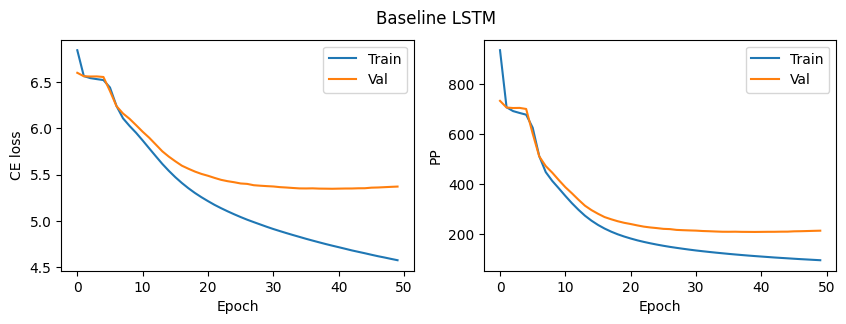

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle('Baseline LSTM')
axs[0].plot(bs_train, label='Train')
axs[0].plot(bs_val, label='Val')
axs[1].plot(np.exp(bs_train), label='Train')
axs[1].plot(np.exp(bs_val), label='Val')


axs[0].set_ylabel('CE loss')
axs[1].set_ylabel('PP')

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.savefig('../assets/baseline_lstm_overfitting.pdf', bbox_inches='tight')
plt.show()

In [13]:
lstmall = df[df.version == 99].copy(deep=True)
la_train = lstmall[lstmall.metric == 'loss/train'].value.values
la_val = lstmall[lstmall.metric == 'loss/val'].value.values

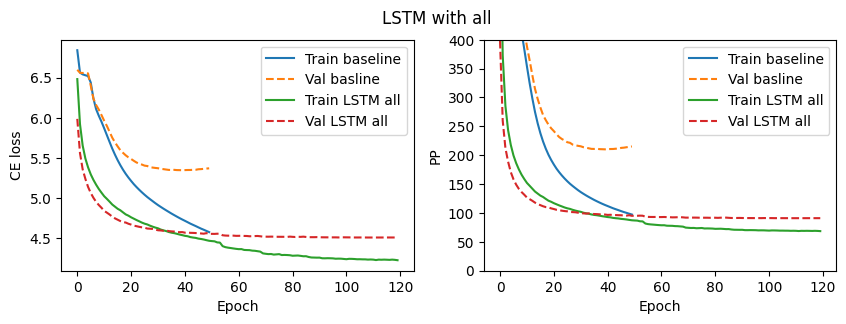

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle('LSTM with all')
axs[0].plot(bs_train, label='Train baseline')
axs[0].plot(bs_val, '--', label='Val basline')
axs[0].plot(la_train, label='Train LSTM all')
axs[0].plot(la_val, '--', label='Val LSTM all')

axs[1].plot(np.exp(bs_train), label='Train baseline')
axs[1].plot(np.exp(bs_val), '--', label='Val basline')
axs[1].plot(np.exp(la_train), label='Train LSTM all')
axs[1].plot(np.exp(la_val), '--', label='Val LSTM all')


axs[0].set_ylabel('CE loss')
axs[1].set_ylabel('PP')
axs[1].set_ylim([0, 400])

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.savefig('../assets/lstm_all.pdf', bbox_inches='tight')
plt.show()

In [15]:
lstmall_refined = df[df.version == 116].copy(deep=True)
la_train_refined = lstmall_refined[lstmall_refined.metric == 'loss/train'].value.values
la_val_refined = lstmall_refined[lstmall_refined.metric == 'loss/val'].value.values

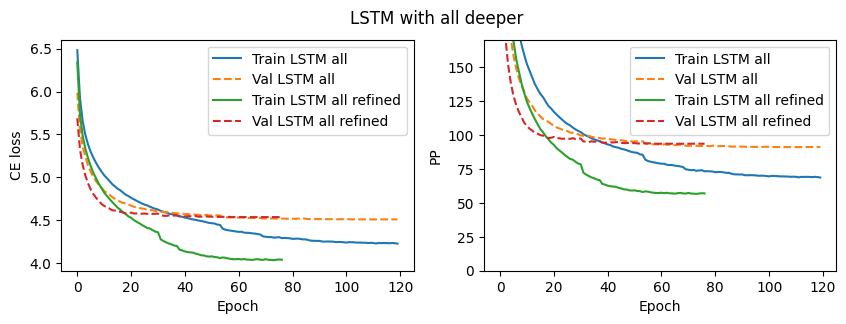

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle('LSTM with all deeper')
axs[0].plot(la_train, label='Train LSTM all')
axs[0].plot(la_val, '--', label='Val LSTM all')
axs[0].plot(la_train_refined, label='Train LSTM all refined')
axs[0].plot(la_val_refined, '--', label='Val LSTM all refined')

axs[1].plot(np.exp(la_train), label='Train LSTM all')
axs[1].plot(np.exp(la_val), '--', label='Val LSTM all')
axs[1].plot(np.exp(la_train_refined), label='Train LSTM all refined')
axs[1].plot(np.exp(la_val_refined), '--', label='Val LSTM all refined')

axs[0].set_ylabel('CE loss')
axs[1].set_ylabel('PP')
axs[1].set_ylim([0, 170])

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.savefig('../assets/lstm_all_refined.pdf', bbox_inches='tight')
plt.show()

In [17]:
mogrifier = df[df.version.isin([36, 44, 58])].copy(deep=True)
mogrifier_train = mogrifier[mogrifier.metric == 'loss/train']
mogrifier_val = mogrifier[mogrifier.metric == 'loss/val']

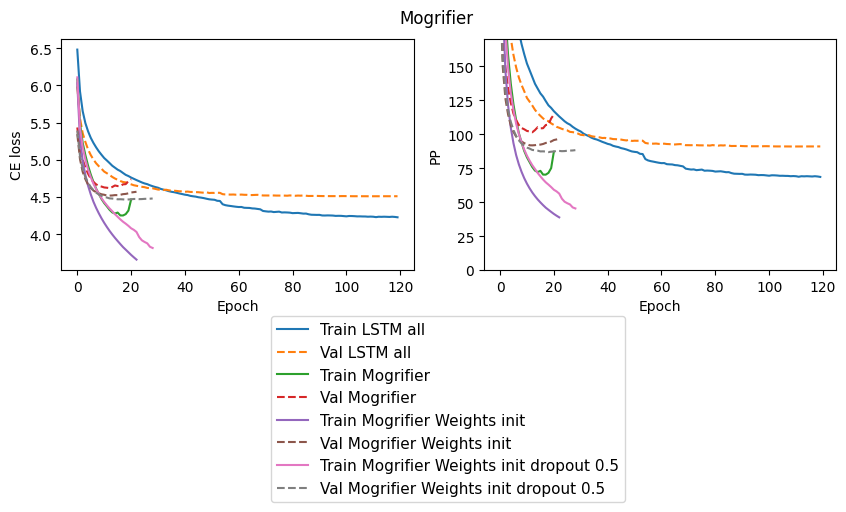

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle('Mogrifier')
axs[0].plot(la_train, label='Train LSTM all')
axs[0].plot(la_val, '--', label='Val LSTM all')
for i, t in zip([36, 44, 58],[
    'Mogrifier',
    'Mogrifier Weights init',
    'Mogrifier Weights init dropout 0.5',
]):
    axs[0].plot(mogrifier_train[mogrifier_train.version == i].value.values, label=f'Train {t}')
    axs[0].plot(mogrifier_val[mogrifier_val.version == i].value.values, '--', label=f'Val {t}')

axs[1].plot(np.exp(la_train), label='Train LSTM all')
axs[1].plot(np.exp(la_val), '--', label='Val LSTM all')
for i, t in zip([36, 44, 58],[
    'Mogrifier',
    'Mogrifier Weights init',
    'Mogrifier Weights init dropout 0.5',
]):
    axs[1].plot(
        np.exp(mogrifier_train[mogrifier_train.version == i].value.values),
        label=f'Train {t}'
    )
    axs[1].plot(
        np.exp(mogrifier_val[mogrifier_val.version == i].value.values),
        '--',
        label=f'Val {t}'
    )

axs[0].set_ylabel('CE loss')
axs[1].set_ylabel('PP')
axs[1].set_ylim([0, 170])

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[1].legend(bbox_to_anchor=(0.4, -0.2), loc='upper right', borderaxespad=0, fontsize=11)
plt.savefig('../assets/mogrifier.pdf', bbox_inches='tight')
plt.show()

In [19]:
print("Best PP: " + str(np.exp(mogrifier_val[mogrifier_val.version == 58].value).min()))

Best PP: 86.84394380886579


In [20]:
df = pd.read_pickle('../test_results.pkl')
embedding_maps = json.load(open("../test_embedding_maps.json", "r"))
embedding_maps = dict(zip(embedding_maps.values(), embedding_maps.keys()))

In [21]:
pp_plot = df[['x_lens', 'ce_loss']].copy(deep=True)
pp_plot['x_lens'] = pp_plot.x_lens.apply(lambda x: x.mean()).values
pp_plot = pp_plot.groupby("x_lens").agg(['mean', 'count']).reset_index()

In [22]:
sentence_lens = pp_plot.x_lens.values
losses = pp_plot.ce_loss['mean'].values
losses = np.array(list(losses))
counts = pp_plot.ce_loss['count'].values
counts = np.array(list(counts))

In [23]:
pp = np.exp(losses)

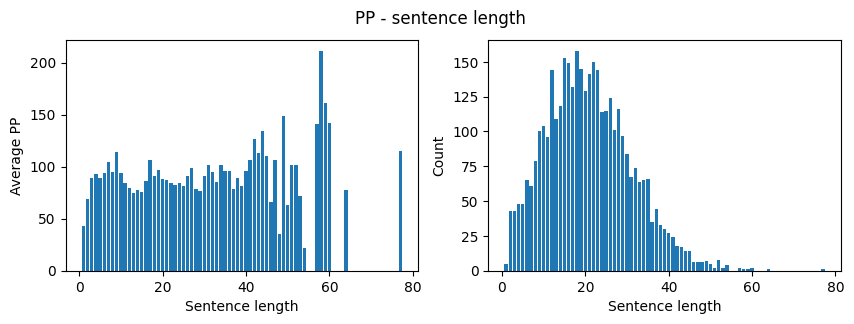

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].bar(sentence_lens, pp)
axs[0].set_xlabel("Sentence length")
axs[0].set_ylabel("Average PP")
axs[1].bar(sentence_lens, counts)
axs[1].set_xlabel("Sentence length")
axs[1].set_ylabel("Count")

plt.suptitle("PP - sentence length")
plt.savefig('../assets/pp_sentence_length.pdf', bbox_inches='tight')
plt.show()

In [25]:
df['outputs'] = df.outputs.apply(lambda x: torch.argmax(F.softmax(torch.tensor(x), dim=1), dim=1).numpy())
y_hat, y = np.concatenate(df.outputs.values), np.concatenate(df.y)

In [26]:
correct = y[y_hat == y]
word_total, count_total = np.unique(y, return_counts=True)
counts = dict(list(zip(list(word_total), list(count_total))))
word, count = np.unique(correct, return_counts=True)
sorted_occurrences = sorted(zip(count, word), reverse=True)

In [27]:
most_guessed = list(map(lambda x: (embedding_maps[x[1]], x[0], counts[x[1]]), sorted_occurrences[:10]))
least_guessed = list(map(lambda x: (embedding_maps[x[1]], x[0], counts[x[1]]), sorted_occurrences[-10:]))

In [28]:
def print_org_table(table):
    for word, val, count in table:
        print(f"| {word} | {val} | {count} |")
        
def print_org_table_perc(table):
    for word, val, count in table:
        print(f"| {word} | {val:.2f}% | {count} |")

In [29]:
print_org_table(most_guessed)

| the | 2761 | 3968 |
| <eos> | 2671 | 3761 |
| <unk> | 2214 | 4606 |
| N | 1757 | 2494 |
| of | 1402 | 2182 |
| to | 1100 | 2024 |
| a | 478 | 1739 |
| 's | 434 | 903 |
| in | 353 | 1470 |
| be | 323 | 384 |


In [30]:
print_org_table(least_guessed)

| acquisition | 1 | 16 |
| acquire | 1 | 11 |
| accounts | 1 | 8 |
| account | 1 | 10 |
| acceptances | 1 | 1 |
| acceptance | 1 | 1 |
| abortions | 1 | 4 |
| 1990s | 1 | 3 |
| 13th | 1 | 9 |
| 12-year | 1 | 2 |


In [31]:
sorted_occurrences = sorted(list(map(lambda x: (x[0] / counts[x[1]], embedding_maps[x[1]], counts[x[1]]), sorted_occurrences)), reverse=True)
sorted_occurrences = list(map(lambda x: (x[1], x[0], x[2]),sorted_occurrences))

In [32]:
most_guessed = sorted_occurrences[90:100]
least_guessed = sorted_occurrences[-10:]

In [33]:
print_org_table_perc(most_guessed)

| jones | 0.96% | 23 |
| officer | 0.94% | 36 |
| york | 0.90% | 71 |
| 'm | 0.90% | 10 |
| breakers | 0.88% | 8 |
| mac | 0.86% | 7 |
| lynch | 0.84% | 19 |
| be | 0.84% | 384 |
| been | 0.83% | 163 |
| francisco | 0.83% | 6 |


In [34]:
print_org_table_perc(least_guessed)

| still | 0.02% | 55 |
| their | 0.02% | 169 |
| last | 0.02% | 116 |
| before | 0.02% | 60 |
| people | 0.02% | 61 |
| over | 0.01% | 78 |
| can | 0.01% | 84 |
| which | 0.01% | 202 |
| but | 0.01% | 160 |
| an | 0.00% | 254 |
